In [1]:
import random
import io
import csv
import numpy as np
import matplotlib.pyplot as plt

from clkhash.field_formats import *
from clkhash.schema import Schema
from clkhash.comparators import NgramComparison, ExactComparison, NumericComparison
from clkhash.clk import generate_clk_from_csv

## Exact Comparison

The exact comparison technique creates high similarity scores if inputs are identical, and low otherwise. This can be useful when comparing data like credit card numbers or email addresses. It is a good choise whenever data is either an exact match or has no similarity at all. 
The main advantage of the *Exact Comparison* technique is that it better separates the similarity scores of the matches from the non-matches (but cannot acount for errors).

We will show this with the following experiment. First, we create a dataset consisting of random 6-digit numbers. Then we compare the dataset with itself, once encoded with the *Exact Comparison*, and twice encoded with the *Ngram Comparison* (uni- and bi-grams) technique.

In [2]:
data = [[i, random.randrange(1000000)] for i in range(5000)]
a_csv = io.StringIO()
csv.writer(a_csv).writerows(data)

We define three different schemas, one for each comparison technique.

In [3]:
fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=NgramComparison(1, True), strategy=BitsPerFeatureStrategy(300))),
]
unigram_schema = Schema(fields, 512)


fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=NgramComparison(2, True), strategy=BitsPerFeatureStrategy(300))),
]
bigram_schema = Schema(fields, 512)


fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=ExactComparison(), strategy=BitsPerFeatureStrategy(300))),
]

exact_schema = Schema(fields, 512)


secret_key = 'password1234'

In [4]:
from bitarray import bitarray
import base64
import anonlink

def deserialize_bitarray(bytes_data):
    ba = bitarray(endian='big')
    data_as_bytes = base64.decodebytes(bytes_data.encode())
    ba.frombytes(data_as_bytes)
    return ba

def deserialize_filters(filters):
    res = []
    for i, f in enumerate(filters):
        ba = deserialize_bitarray(f)
        res.append(ba)
    return res

def sim_scores_from_clks(clks_a, clks_b, threshold):
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    return results_candidate_pairs[0]

generate the CLKs according to the three different schemas.

In [5]:
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, unigram_schema, header=False)
clks_a_unigram = deserialize_filters(hashed_data_a)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, bigram_schema, header=False)
clks_a_bigram = deserialize_filters(hashed_data_a)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, exact_schema, header=False)
clks_a_exact = deserialize_filters(hashed_data_a)

generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 8.57kclk/s, mean=229, std=5.98]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 13.6kclk/s, mean=228, std=5.83]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 13.6kclk/s, mean=227, std=5.74]


We do an exhaustive pairwise comparison for the CLKs and keep the similarities above 0.5.

In [6]:
sim_scores_unigram = sim_scores_from_clks(clks_a_unigram, clks_a_unigram, 0.5)
sim_scores_bigram = sim_scores_from_clks(clks_a_bigram, clks_a_bigram, 0.5)
sim_scores_exact = sim_scores_from_clks(clks_a_exact, clks_a_exact, 0.5)

We will plot the similarity scores as histograms. Note the log scale of the y-axis.

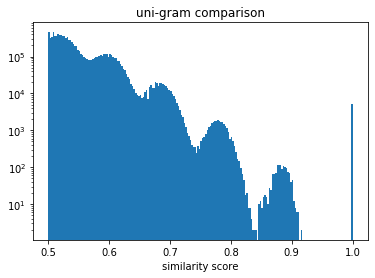

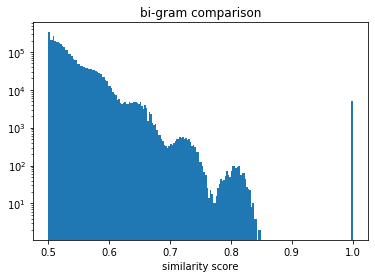

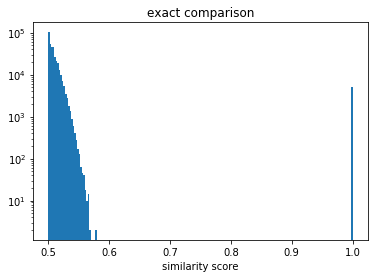

In [7]:
import matplotlib.pyplot as plt
plt.hist(sim_scores_unigram, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('uni-gram comparison')
plt.show()
plt.hist(sim_scores_bigram, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('bi-gram comparison')
plt.show()
plt.hist(sim_scores_exact, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('exact comparison')
plt.show()

The true matches all lie on the vertical line above the 1.0. We can see that the *Exact Comparison* technique significantly widens the gap between matches and non-matches. The better the separation between matches and non-matches, the easier it will be for the solver to find the correct linkage.

## Numeric Comparison
This technique enables numerical comparisons of integers or floating point numbers.

Comparing numbers creates an interesting challenge. The pairs (1000, 1001) and (1000, 999) are equally similiar. String-based techniques like n-gram comparison will produce unexpected results, as the first pair has three digits in common, compared to none in the last pair. 

We have implemented a technique, where the numerical distance between two numbers relate to the similarity of the produced tokens.

We generate a dataset with one column of random 7-digit integers, and a second dataset where we alter the integers of the first dataset by +/- 100. 

In [8]:
data_A = [[i, random.randrange(10000000)] for i in range(5000)]
data_B = [[i, x + random.randint(-100,100)] for i,x in data_A]

In [9]:
a_csv = io.StringIO()
b_csv = io.StringIO()
csv.writer(a_csv).writerows(data_A)
csv.writer(b_csv).writerows(data_B)

We define two linkage schemas, one for postitional uni-gram comparison and one for numeric comparison.

In [10]:
fields = [
    Ignore('rec_id'),
    IntegerSpec('random', 
                FieldHashingProperties(comparator=NgramComparison(1, True), 
                                       strategy=BitsPerFeatureStrategy(301))),
]
unigram_schema = Schema(fields, 512)

fields = [
    Ignore('rec_id'),
    IntegerSpec('random', 
                FieldHashingProperties(comparator=NumericComparison(threshold_distance=500, resolution=150),
                                       strategy=BitsPerFeatureStrategy(301))),
]
numeric_schema = Schema(fields, 512)

secret_key = 'password1234'

In [11]:
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, unigram_schema, header=False)
clks_a_unigram = deserialize_filters(hashed_data_a)
b_csv.seek(0)
hashed_data_b = generate_clk_from_csv(b_csv, secret_key, unigram_schema, header=False)
clks_b_unigram = deserialize_filters(hashed_data_b)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, numeric_schema, header=False)
clks_a_numeric = deserialize_filters(hashed_data_a)
b_csv.seek(0)
hashed_data_b = generate_clk_from_csv(b_csv, secret_key, numeric_schema, header=False)
clks_b_numeric = deserialize_filters(hashed_data_b)

generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 9.82kclk/s, mean=229, std=5.96]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 13.5kclk/s, mean=229, std=5.82]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:03<00:00, 1.28kclk/s, mean=228, std=5.88]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:03<00:00, 1.57kclk/s, mean=228, std=5.77]


First, we will look at the similarity score distributions.

In [12]:
def grouped_sim_scores_from_clks(clks_a, clks_b, threshold):
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    matches = []
    non_matches = []
    sims, ds_is, (rec_id0, rec_id1) = results_candidate_pairs
    for sim, rec_i0, rec_i1 in zip(sims, rec_id0, rec_id1):
        if rec_i0 == rec_i1:
            matches.append(sim)
        else:
            non_matches.append(sim)
    return matches, non_matches

sims_matches_unigram, sims_non_matches_unigram = grouped_sim_scores_from_clks(clks_a_unigram, clks_b_unigram, 0.5)
sims_matches_numeric, sims_non_matches_numeric = grouped_sim_scores_from_clks(clks_a_numeric, clks_b_numeric, 0.5)

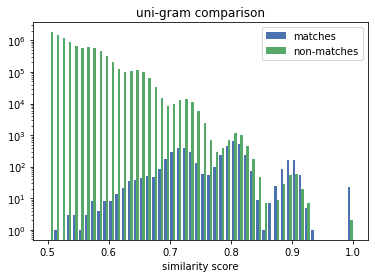

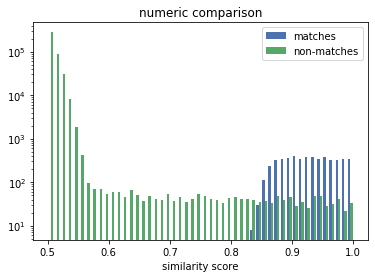

In [13]:
plt.style.use('seaborn-deep')

plt.hist([sims_matches_unigram, sims_non_matches_unigram], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('uni-gram comparison')
plt.show()

plt.hist([sims_matches_numeric, sims_non_matches_numeric], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('numeric comparison')
plt.show()

The distribution for the numeric comparison is very different to the uni-gram one. The similarity scores of the matches in the uni-gram case are mixed-in with the scores of the non-matches, making it challenging for a solver to decide if a similarity score denotes a match or a non-match.

The numeric comparison produces similarity scores for matches that mirrors the distribution of the numeric distances. More importanty, there is a good separation between the scores for the matches and the ones for the non-matches. The former are all above 0.8, whereas the latter are almost all (note the log scale) below 0.6.

In the next step, we will see how well the solver can find a linkage solution for the different CLKs.

In [14]:
def mapping_from_clks(clks_a, clks_b, threshold):
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    solution = anonlink.solving.greedy_solve(results_candidate_pairs)
    print('Found {} matches'.format(len(solution)))
    return set( (a,b) for ((_, a),(_, b)) in solution)

true_matches = set((i,i) for i in range(5000))
  
def describe_matching_quality(found_matches):
 
    tp = len(true_matches & found_matches)
    fp = len(found_matches - true_matches)
    fn = len(true_matches - found_matches)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print('Precision: {:.3f}, Recall: {:.3f}'.format(precision, recall))

In [15]:
print('results for numeric comparisons')
describe_matching_quality(mapping_from_clks(clks_a_numeric, clks_b_numeric, 0.8))

results for numeric comparisons
Found 4985 matches
Precision: 0.953, Recall: 0.949


In [16]:
print('results for unigram comparisons')
describe_matching_quality(mapping_from_clks(clks_a_unigram, clks_b_unigram, 0.7))

results for unigram comparisons
Found 4656 matches
Precision: 0.417, Recall: 0.387


As expected, we can see that the solver does a lot better when given the CLKs, generated with the numeric comparison technique.